<a href="https://colab.research.google.com/github/moriyad12/Face-Recognition/blob/main/Face-Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation and imports

In [ ]:
import os
import cupy as cp
import numpy as np
import zipfile
from PIL import Image
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import warnings

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#constants
non_face_directory_path = "content/non_face/"
face_directory_path = "content/"

In [ ]:
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('content')

In [ ]:
with zipfile.ZipFile('non_face.zip', 'r') as zip_ref:
    zip_ref.extractall('content')



---



# 2. Generate the Data Matrix and the Label vector

In [ ]:
def read_pgm(pgm):
    # Read header and validate file format
    header = pgm.readline().decode().strip()
    assert header == "P5"

    # Read width, height, and maximum gray value
    (width, height) = [int(i) for i in pgm.readline().split()]
    depth = int(pgm.readline())
    assert depth <= 255

    # Read pixel data
    data = []
    for y in range(height):
        row = []
        for x in range(width):
            row.append(ord(pgm.read(1)))  # Read one byte (pixel value)
        data.append(row)  # Append the row to the data list

    return data  # Return the pixel data

In [ ]:
# Initialize an empty list to store flattened pixel vectors
all_flatten_vectors = []

# Iterate over subjects
for i in range(1, 41):
    # Iterate over images per subject
    for j in range(1, 11):
        # Construct file path
        file_path = f'/content/content/s{i}/{j}.pgm'

        # Open PGM file in binary mode
        with open(file_path, 'rb') as pgm_file:
            # Read PGM file and extract pixel data
            raster_data = read_pgm(pgm_file)

        # Flatten pixel data and append flattened vector to the list
        flatten_vector = [pixel for row in raster_data for pixel in row]
        all_flatten_vectors.append(flatten_vector)

# Convert the list of flattened vectors to a Cupy array
D = cp.array(all_flatten_vectors)

# Create target labels (subjects)
y = cp.array([i for i in range(1, 41) for _ in range(10)])



---



# 3.Split the Dataset into Training and Test sets

In [ ]:
# Select odd rows of the data for training
training_data = D[1::2]

# Select even rows of the data for testing
testing_data = D[0::2]

# Select odd elements of the labels for training
training_data_labels = y[1::2]

# Select even elements of the labels for testing
testing_data_labels = y[0::2]

# General functions

In [ ]:
def center_data(X):
  # Calculate the mean value for each feature across all samples
  mean_per_feature = cp.mean(X, axis=0, keepdims=True)

  # Center the data by subtracting the mean value from each feature
  Z = X - mean_per_feature

  return Z

In [ ]:
def compute_accuracy(X_train, Y_train, X_test, Y_test, k):
    # Convert labels to integer type
    Y_train = Y_train.astype(int)
    Y_test = Y_test.astype(int)

    # Initialize KNN classifier with distance weights
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')

    # Fit the classifier on training data
    knn.fit(X_train, Y_train)

    # Predict labels for test data
    predicted_labels = knn.predict(X_test)

    # Compute confusion matrix
    confusion_mat = confusion_matrix(Y_test, predicted_labels)

    # Compute overall accuracy
    overall_accuracy = accuracy_score(Y_test, predicted_labels)

    # Compute and print accuracy for each class (label)
    unique_labels = np.unique(Y_test)
    for label in [1 , 0]:
        indices = np.where(Y_test == label)[0]
        success_cases_label = np.sum(predicted_labels[indices] == label)
        total_cases_label = len(indices)
        print(f"Success cases for Label {label}: {success_cases_label} / {total_cases_label} (Accuracy: {success_cases_label / total_cases_label:.2%})")

    # Return overall accuracy, indices, and predicted labels
    return overall_accuracy, indices, predicted_labels


In [ ]:
def plot_accuracy_vs_k(K_values, accuracies, method):
    plt.plot(K_values, accuracies, marker='o')
    plt.title(f'Accuracy vs. Number of Neighbors (K) for {method}')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(K_values)
    plt.show()



---



# 4.Classification using PCA

In [ ]:
def PCA(training_data, alpha):
    # Center the training data
    Z = center_data(training_data)

    # Compute the covariance matrix
    C = cp.dot(Z.T, Z) * (1 / Z.shape[0])

    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = cp.linalg.eigh(C)

    # Sort the eigenvalues in descending order and rearrange the corresponding eigenvectors accordingly
    sorted_idx = cp.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]

    # Compute the cumulative explained variance ratio
    f = cp.cumsum(eigenvalues) / cp.sum(eigenvalues)

    # Determine the number of principal components required to explain at least 'alpha' fraction of the total variance
    r = cp.argmax(f >= alpha)

    # Select the first 'r' eigenvectors as principal components
    Ur = eigenvectors[:, :r]

    # Return the transpose of the selected principal components, ensuring they are in rows
    return cp.real(Ur.T)

In [ ]:
# Define the list of alpha values
alphas = [0.8, 0.85, 0.9, 0.95]

# Initialize an empty dictionary to store the principal component matrices for each alpha value
U_matrices = {}

# Iterate over each alpha value
for alpha in alphas:
    # Compute the principal component matrix for the given alpha and store it in the dictionary
    U_matrices[alpha] = PCA(training_data, alpha)

In [ ]:
# Initialize dictionaries to store projected training and test data for each alpha value
projected_training = {}
projected_test = {}

# Iterate over each alpha value and its corresponding principal component matrix
for alpha, U in U_matrices.items():
    # Project the training data onto the principal components and store the result
    projected_training[alpha] = cp.dot(U, training_data.T)

    # Project the test data onto the principal components and store the result
    projected_test[alpha] = cp.dot(U, testing_data.T)

In [ ]:
for alpha in alphas:
    accuarcy = compute_accuracy(cp.asnumpy(projected_training[alpha].T), cp.asnumpy(training_data_labels), cp.asnumpy(projected_test[alpha].T), cp.asnumpy(testing_data_labels),1)[0]
    print(f'Accuracy for alpha = {alpha} : {accuarcy}')



```
Accuracy for alpha = 0.8 : 0.93
Accuracy for alpha = 0.85 : 0.94
Accuracy for alpha = 0.9 : 0.945
Accuracy for alpha = 0.95 : 0.935
```



### Can you find a relation between alpha and classification accuracy?
ans: higher values of alpha correspond to retaining more principal components, which capture more variance in the data. This often leads to better representation of the original data. However, it's important to note that including too many principal components can lead to overfitting, where the model captures noise rather than useful signal in the data.



---



# 5.Linear Discriminant Analysis

In [ ]:
def classify_data(Z, Y):
    # Get unique labels
    unique_labels = np.unique(Y)

    # Create an empty dictionary to store data samples for each label
    D = {label: [] for label in unique_labels}

    # Separate data by labels
    for label in unique_labels:
        # Get indices where label equals the current unique label
        indices = np.where(Y == label)[0]

        # Extract data samples corresponding to the current label
        data_samples = Z[indices]

        # Store the data samples in the dictionary
        D[label] = data_samples

    # Return the dictionary containing data samples for each label
    return D

In [ ]:
def centralize_data_in_dict(data_dict):
    centralized_dict = {}

    # Calculate mean of every class and centralize each class
    for label, data_samples in data_dict.items():
        # Calculate the mean of data samples for the current class
        class_mean = np.mean(data_samples, axis=0)

        # Centralize data samples by subtracting the mean
        centralized_samples = data_samples - class_mean

        # Store centralized data samples in the new dictionary
        centralized_dict[label] = centralized_samples

    # Return the dictionary containing centralized data samples for each class
    return centralized_dict

In [ ]:
def Calculate_between_class_scatter_matrix(Z, Y, D):
    # Get unique labels
    unique_labels = np.unique(Y)

    # Calculate class means
    class_means = {label: np.mean(D[label], axis=0) for label in unique_labels}

    # Calculate overall mean
    overall_mean = np.mean(Z, axis=0)

    # Initialize between-class scatter matrix B
    B = np.zeros((Z.shape[1], Z.shape[1]))

    # Calculate between-class scatter matrix B
    for label in unique_labels:
        # Calculate difference between class mean and overall mean
        mean_diff = class_means[label] - overall_mean

        # Update between-class scatter matrix B
        B += len(D[label]) * np.outer(mean_diff, mean_diff)

    # Return the between-class scatter matrix B
    return B

In [ ]:
def Calculate_within_class_scatter_matrix(X, Y, D):
    # Get unique labels
    unique_labels = np.unique(Y)

    # Initialize within-class scatter matrix S
    S = np.zeros((X.shape[1], X.shape[1]))

    # Calculate within-class scatter matrix S
    for label in unique_labels:
        # Calculate the covariance matrix for each class
        covariance_matrix = np.dot(D[label].T, D[label])

        # Update the within-class scatter matrix by adding the covariance matrix
        S += covariance_matrix

    # Return the within-class scatter matrix S
    return S

In [ ]:
def calculate_projection_matrix(eigenvalues, eigenvectors):
    # Sort eigenvalues and eigenvectors based on eigenvalues
    sorted_idx = np.argsort(eigenvalues)[::-1]  # Get indices to sort eigenvalues in descending order
    eigenvectors = eigenvectors[:, sorted_idx]  # Sort eigenvectors based on sorted eigenvalues
    top_eigenvectors = eigenvectors[:, :len(eigenvectors)-1]  # Select top eigenvectors except for the last one

    # Return the top eigenvectors as the projection matrix
    return top_eigenvectors

In [ ]:
def LDA(X, Y):
    # Classify the data
    D = classify_data(X, Y)

    # Calculate between-class scatter matrix
    B = Calculate_between_class_scatter_matrix(X, Y, D)

    # Centralize data for each class
    D = centralize_data_in_dict(D)

    # Calculate within-class scatter matrix
    S = Calculate_within_class_scatter_matrix(X, Y, D)

    # Compute the matrix W using the generalized eigenvalue problem
    W = np.dot(linalg.pinv(S), B)

    # Compute eigenvalues and eigenvectors of W
    eigenvalues, eigenvectors = linalg.eig(W)

    # Calculate the projection matrix P
    P = calculate_projection_matrix(eigenvalues, eigenvectors)

    # Return the real part of the projection matrix (in case of complex eigenvalues)
    return np.real(P)

In [ ]:
projection_matrix = LDA(training_data.get(),training_data_labels.get())

In [ ]:
def project_data(data, projection_matrix):
    return np.dot(data,projection_matrix)

In [ ]:
train_data=project_data(training_data.get(), projection_matrix)
test_data=project_data(testing_data.get(), projection_matrix)

In [ ]:
for k in range(1, 8, 2):
    print(f'Accuracy for k={k}:', compute_accuracy(train_data, training_data_labels.get(), test_data, testing_data_labels.get(), k)[0])



```
Accuracy for k=1: 0.955
Accuracy for k=3: 0.945
Accuracy for k=5: 0.87
Accuracy for k=7: 0.86
```





---



# 6.Classifier Tuning

In [ ]:
K_values = [1, 3, 5, 7]

# Compute accuracy for different K values using K-NN classifier for PCA
for alpha in alphas:
  accuracies_knn = []
  for k in K_values:
      accuracies_knn.append(compute_accuracy(cp.asnumpy(projected_training[alpha].T), cp.asnumpy(training_data_labels), cp.asnumpy(projected_test[alpha].T), cp.asnumpy(testing_data_labels), k)[0])

  # Plot the performance measure (accuracy) against the K value for K-NN classifier with PCA
  plot_accuracy_vs_k(K_values, accuracies_knn, f'PCA : alpha = {alpha}')
accuracies_LDA_knn = []
for k in K_values:
  accuracies_LDA_knn.append(compute_accuracy(train_data, training_data_labels.get(), test_data, testing_data_labels.get(), k)[0])
plot_accuracy_vs_k(K_values, accuracies_LDA_knn,"LDA")

### **Results:**
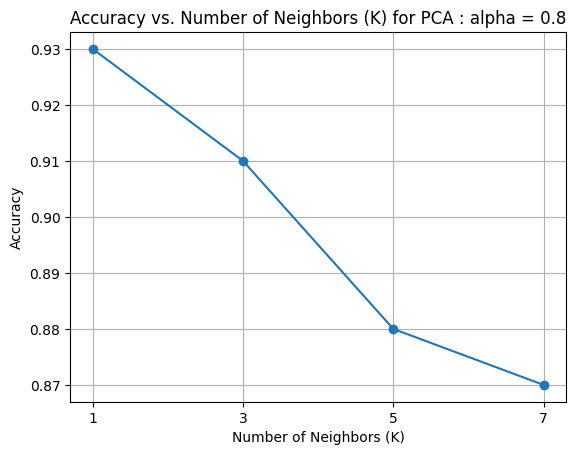
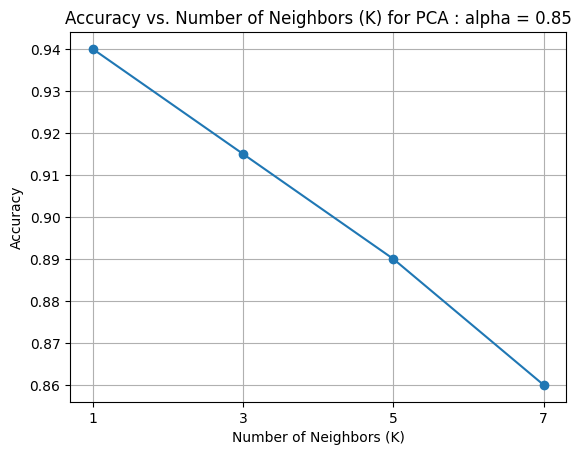
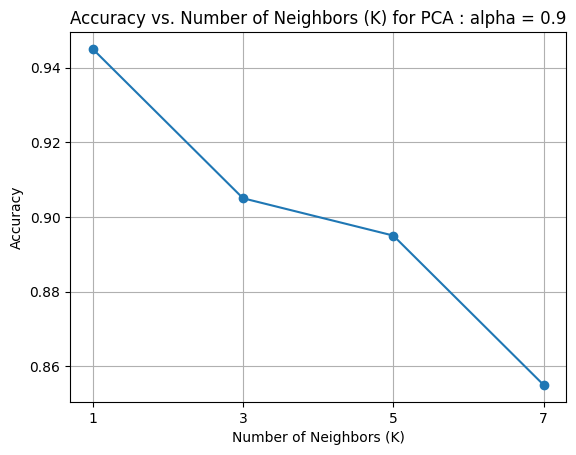
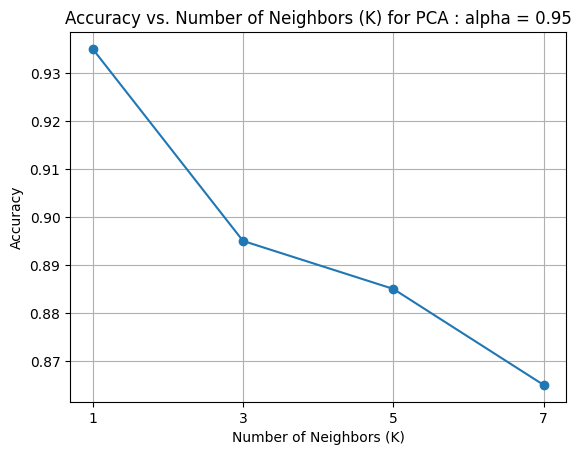
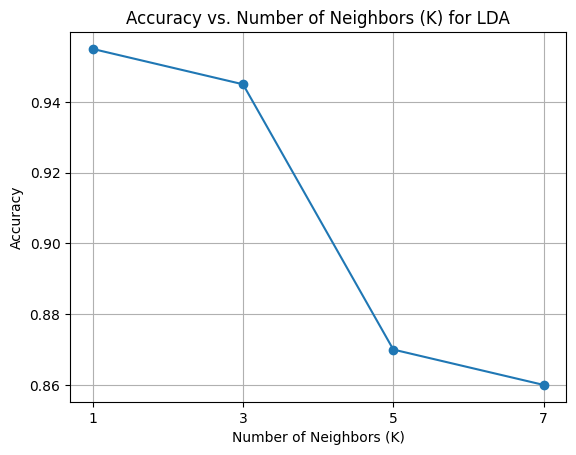



---



# 7.Classification Part: Face vs Non-face

In [ ]:
def convert_to_greyscale(img):
  return img.convert('L')
def resize_img(img, new_width, new_height):
  resized_img  = img.resize((new_width, new_height))
  return resized_img

In [ ]:
flatten_vectors = []
try:
    all_files = os.listdir(non_face_directory_path)
    for filename in all_files:
            if os.path.isfile(os.path.join(non_face_directory_path, filename)):
                img = Image.open(non_face_directory_path + filename)
                grey_img = convert_to_greyscale(img)
                resized_img = resize_img(grey_img, 92, 112)
                flatten_vector = cp.array(resized_img).flatten()
                assert len(flatten_vector) == 10304
                flatten_vectors.append(flatten_vector)
except Exception as e:
    print(f"Error while processing files here: {e}")

In [ ]:
# prepare training and testing data for faces and nonfaces
# testing data will vary according to changing number of faces to non faces each time

def train_model(face_training_size, non_face_training_size):
    face_training_data = cp.array(D[:face_training_size])
    face_training_data_labels = cp.ones(face_training_size)

    non_face_training_data = cp.array(flatten_vectors[:non_face_training_size])
    non_face_training_data_labels = cp.zeros(non_face_training_size)

    all_training_data = cp.concatenate((face_training_data, non_face_training_data), axis=0)
    all_training_data_labels = cp.concatenate((face_training_data_labels, non_face_training_data_labels), axis=0)

    return all_training_data, all_training_data_labels

In [ ]:
all_training_data, all_training_data_labels = train_model(100, 100)

In [ ]:
def dimensionality_reduction_PCA(alpha, all_training_data, all_testing_data):
    centered_training_data = center_data(all_training_data)
    C = cp.cov(centered_training_data.T) * (centered_training_data.shape[0] - 1) / (centered_training_data.shape[0])
    eigenvalues, eigenvectors = cp.linalg.eigh(C)
    U = PCA(centered_training_data, alpha, eigenvalues, eigenvectors)
    projected_training_data = cp.dot(U, all_training_data.T)
    projected_testing_data = cp.dot(U, all_testing_data.T)
    return projected_training_data, projected_testing_data

In [ ]:
def dimensionality_reduction_LDA(all_training_data, all_training_data_labels, all_testing_data):
    U = LDA(all_training_data.get(), all_training_data_labels.get())
    projected_training_data = project_data(all_training_data.get(), U.get())
    projected_testing_data = project_data(all_testing_data.get(), U.get())
    return projected_training_data, projected_testing_data

In [ ]:
def prepare_testing_data(alpha, face_testing_size, non_face_testing_size, all_training_data, all_training_data_labels , dimensionality_reduction_algorithm):
    projected_training_data, projected_testing_data = [], []
    training_size = int(len(all_training_data) / 2)
    face_testing_data = cp.array(D[training_size : training_size + face_testing_size])
    face_testing_data_labels = cp.ones(face_testing_size)
    non_face_testing_data = cp.array(flatten_vectors[training_size : training_size + non_face_testing_size])
    non_face_testing_data_labels = cp.zeros(non_face_testing_size)
    all_testing_data = cp.concatenate((face_testing_data, non_face_testing_data), axis=0)
    all_testing_data_labels = cp.concatenate((face_testing_data_labels, non_face_testing_data_labels), axis=0)
    if ( dimensionality_reduction_algorithm == "PCA" ):
      projected_training_data, projected_testing_data = dimensionality_reduction_PCA(alpha, all_training_data, all_testing_data)
    elif ( dimensionality_reduction_algorithm == "LDA" ):
      projected_training_data, projected_testing_data = dimensionality_reduction_LDA(all_training_data, all_training_data_labels, all_testing_data)
    return projected_training_data, projected_testing_data, all_testing_data, all_testing_data_labels

In [ ]:
# testing
def testing(all_training_data, all_training_data_labels, dimentiality_reduction_algorithm):
  for alpha in [0.8]:
    for k in [1, 2, 3, 5, 7]:
      for face_testing_size in [100, 200]:
        for non_face_testing_size in [100, 100, 300]:
          projected_training_data, projected_testing_data, all_testing_data, all_testing_data_labels = prepare_testing_data(
                                                                                                          alpha,
                                                                                                          face_testing_size,
                                                                                                          non_face_testing_size,
                                                                                                          all_training_data,
                                                                                                          all_training_data_labels,
                                                                                                          dimentiality_reduction_algorithm
                                                                                                          )
          print(
              f"For k = {k}, "
              f"Training set size = {len(all_training_data)} ({int(len(all_training_data) / 2)} face,  {int(len(all_training_data) / 2)} nonface), "
              f"Testing set size = {non_face_testing_size + face_testing_size} ("
              f"{non_face_testing_size} nonface, {face_testing_size} face)"
          )

          if ( dimentiality_reduction_algorithm == "QDA" ):
            overall_accuracy = dimensionality_reduction_QDA(all_training_data, all_training_data_labels, all_testing_data, all_testing_data_labels)
          elif ( dimentiality_reduction_algorithm == "KPCA" ):
            overall_accuracy = dimensionality_reduction_kernel_PCA(all_training_data, all_training_data_labels, all_testing_data, all_testing_data_labels, k, alpha)
          else :
            overall_accuracy, success_indices, predicted_labels = compute_accuracy(cp.asnumpy(projected_training_data), cp.asnumpy(all_training_data_labels), cp.asnumpy(projected_testing_data), cp.asnumpy(all_testing_data_labels),k)
          print(f"Overall Accuracy: {overall_accuracy * 100} %")
          print("-" * 150)


In [ ]:
print("Testing with PCA")
testing(all_training_data, all_training_data_labels, "PCA")

print("Testing with LDA")
testing(all_training_data, all_training_data_labels, "LDA")

print("Testing with QDA")
testing(all_training_data, all_training_data_labels, "QDA")

print("Testing with Kernel PCA")
testing(all_training_data, all_training_data_labels, "KPCA")

Testing with Kernel PCA
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 93.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 93.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Lab



---



# 8.A QDA - Quadratic Discriminant Analysis (Variation of LDA)

In [ ]:
def compute_accuracy_QDA(predictions, all_testing_data_labels):
    correct_predictions = cp.sum(predictions == all_testing_data_labels)
    total_predictions = len(predictions)
    accuracy = (correct_predictions / total_predictions)
    return accuracy

def dimensionality_reduction_QDA(all_training_data, all_training_data_labels, all_testing_data, all_testing_data_labels):
  qda = QuadraticDiscriminantAnalysis()
  qda.fit(all_training_data.get(), all_training_data_labels.get())
  predictions = cp.array(qda.predict(all_testing_data.get()))
  overall_accuracy = compute_accuracy_QDA(predictions, all_testing_data_labels)
  return overall_accuracy

# 8.B Kernel PCA - variation of PCA


In [ ]:
def dimensionality_reduction_kernel_PCA(train, train_labels, test, test_labels, k, alpha):
  sc = StandardScaler()
  X_train = sc.fit_transform(train.get())
  X_test = sc.transform(test.get())
  kpca = KernelPCA(n_components=2, kernel="rbf")
  X_train_kpca = kpca.fit_transform(X_train)
  X_test_kpca = kpca.transform(X_test)
  accuracy, success_indices, predicted_labels = compute_accuracy(X_train_kpca, train_labels.get(), X_test_kpca, test_labels.get(), k)
  return accuracy



---



# 9.Computing success and failure cases for some PCA cases

In [ ]:
def success_and_failure_cases(all_training_data, all_training_data_labels, dimensionality_reduction_algorithm):
    for alpha in [0.9]:
      for k in [2]:
        for face_testing_size in [200]:
          for non_face_testing_size in [100]:
            projected_training_data, projected_testing_data, all_testing_data, all_testing_data_labels = prepare_testing_data(
                                                                                                            alpha,
                                                                                                            face_testing_size,
                                                                                                            non_face_testing_size,
                                                                                                            all_training_data,
                                                                                                            all_training_data_labels,
                                                                                                            dimensionality_reduction_algorithm
                                                                                                            )

            overall_accuracy, indices, predicted  = compute_accuracy(cp.asnumpy(projected_training_data.T), cp.asnumpy(all_training_data_labels), cp.asnumpy(projected_testing_data.T), cp.asnumpy(all_testing_data_labels),k)
            success_cases_non_faces = np.where(predicted[200:] == 0)[0] + 200
            failure_cases_non_faces = np.where(predicted[200:] != 0)[0] + 200
            success_cases_faces = np.where(predicted[:200] == 1)[0]
            failure_cases_faces = np.where(predicted[:200] != 1)[0]
            success_cases = np.concatenate((success_cases_faces, success_cases_non_faces))
            failure_cases = np.concatenate((failure_cases_faces, failure_cases_non_faces))
            reshaped_images = [cp.array(all_testing_data[i]).reshape((112, 92)).get().astype(np.uint8) for i in success_cases]

            fig, axes = plt.subplots(52, 5, figsize=(30, 200))
            fig.suptitle("Success Cases", fontsize=30, fontweight='bold')
            for i, ax in enumerate(axes.flat):
                ax.imshow(reshaped_images[i], cmap='gray')
                ax.axis('off')
                ax.set_title(f"Image {i+1}", fontsize=15)
            plt.show()
            reshaped_images = [cp.array(all_testing_data[i]).reshape((112, 92)).get().astype(np.uint8) for i in failure_cases]
            fig, axes = plt.subplots(6, 5, figsize=(20, 15))
            for i, ax in enumerate(axes.flat):
                ax.imshow(reshaped_images[i], cmap='gray')
                ax.axis('off')
                ax.set_title(f"Image {i+1}", fontsize=10)
            plt.show()

success_and_failure_cases(all_training_data, all_training_data_labels, "PCA")



---



# 10.Relation between accuracy and number of non faces

In [ ]:
def testing_Relation_Face_nonFace(face_testing_size, dimentiality_reduction_algorithm):
    alpha_values = [0.8]
    non_face_testing_sizes = [100, 200, 300]
    k_values = [1,5]
    results = {}
    for alpha in alpha_values:
        for k in k_values:
            accuracies = []
            for non_face_testing_size in non_face_testing_sizes:
                projected_training_data, projected_testing_data, all_testing_data, all_testing_data_labels = prepare_testing_data(
                                                                                                            alpha,
                                                                                                            face_testing_size,
                                                                                                            non_face_testing_size,
                                                                                                            all_training_data,
                                                                                                            all_training_data_labels,
                                                                                                            dimentiality_reduction_algorithm
                                                                                                            )
                overall_accuracy, indices, predicted = compute_accuracy(cp.asnumpy(projected_training_data.T), cp.asnumpy(all_training_data_labels), cp.asnumpy(projected_testing_data.T), cp.asnumpy(all_testing_data_labels),k)
                accuracies.append(overall_accuracy)
            results[(alpha, k)] = accuracies

    plt.figure(figsize=(10, 6))
    for alpha, k in results.keys():
        plt.plot(non_face_testing_sizes, results[(alpha, k)], label=f'Alpha={alpha}, k={k}')

    plt.xlabel('Non-face Testing Size')
    plt.ylabel('Accuracy')
    plt.title(f'Relation between Non-face Testing Size and Accuracy and face_testing_size = {face_testing_size}')
    plt.legend()
    plt.show()

In [ ]:
for face_testing_size in [100, 200]:
  testing_Relation_Face_nonFace(face_testing_size, "PCA")



---



# 11.Testing Results



### Testing with PCA
alpha (when increases the accuracy doesn't always increase) -> noise
k (when increases the accuracy doesn't always increase) -> closely related people and pictures overfitting occurs when a machine learning model learns the training data too well, to the extent that it captures noise or random fluctuations in the data as if they were meaningful patterns. In other words, the model becomes overly complex and fits the training data too closely, losing its ability to generalize to unseen data.

```
For alpha = 0.8, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 94 / 100 (Accuracy: 94.00%)
Success cases for Label 0: 40 / 100 (Accuracy: 40.00%)
Overall Accuracy: 67.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 94 / 100 (Accuracy: 94.00%)
Success cases for Label 0: 89 / 200 (Accuracy: 44.50%)
Overall Accuracy: 61.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 94 / 100 (Accuracy: 94.00%)
Success cases for Label 0: 132 / 300 (Accuracy: 44.00%)
Overall Accuracy: 56.49999999999999 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 193 / 200 (Accuracy: 96.50%)
Success cases for Label 0: 40 / 100 (Accuracy: 40.00%)
Overall Accuracy: 77.66666666666666 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 193 / 200 (Accuracy: 96.50%)
Success cases for Label 0: 89 / 200 (Accuracy: 44.50%)
Overall Accuracy: 70.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 193 / 200 (Accuracy: 96.50%)
Success cases for Label 0: 132 / 300 (Accuracy: 44.00%)
Overall Accuracy: 65.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 92 / 100 (Accuracy: 92.00%)
Success cases for Label 0: 48 / 100 (Accuracy: 48.00%)
Overall Accuracy: 70.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 92 / 100 (Accuracy: 92.00%)
Success cases for Label 0: 107 / 200 (Accuracy: 53.50%)
Overall Accuracy: 66.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 92 / 100 (Accuracy: 92.00%)
Success cases for Label 0: 158 / 300 (Accuracy: 52.67%)
Overall Accuracy: 62.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 189 / 200 (Accuracy: 94.50%)
Success cases for Label 0: 48 / 100 (Accuracy: 48.00%)
Overall Accuracy: 79.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 189 / 200 (Accuracy: 94.50%)
Success cases for Label 0: 107 / 200 (Accuracy: 53.50%)
Overall Accuracy: 74.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 189 / 200 (Accuracy: 94.50%)
Success cases for Label 0: 158 / 300 (Accuracy: 52.67%)
Overall Accuracy: 69.39999999999999 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 31 / 100 (Accuracy: 31.00%)
Overall Accuracy: 65.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 76 / 200 (Accuracy: 38.00%)
Overall Accuracy: 58.666666666666664 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 106 / 300 (Accuracy: 35.33%)
Overall Accuracy: 51.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 200 / 200 (Accuracy: 100.00%)
Success cases for Label 0: 31 / 100 (Accuracy: 31.00%)
Overall Accuracy: 77.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 200 / 200 (Accuracy: 100.00%)
Success cases for Label 0: 76 / 200 (Accuracy: 38.00%)
Overall Accuracy: 69.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 200 / 200 (Accuracy: 100.00%)
Success cases for Label 0: 106 / 300 (Accuracy: 35.33%)
Overall Accuracy: 61.199999999999996 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 69 / 100 (Accuracy: 69.00%)
Overall Accuracy: 82.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 145 / 200 (Accuracy: 72.50%)
Overall Accuracy: 80.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 218 / 300 (Accuracy: 72.67%)
Overall Accuracy: 78.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 192 / 200 (Accuracy: 96.00%)
Success cases for Label 0: 69 / 100 (Accuracy: 69.00%)
Overall Accuracy: 87.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 192 / 200 (Accuracy: 96.00%)
Success cases for Label 0: 145 / 200 (Accuracy: 72.50%)
Overall Accuracy: 84.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 192 / 200 (Accuracy: 96.00%)
Success cases for Label 0: 218 / 300 (Accuracy: 72.67%)
Overall Accuracy: 82.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 74 / 100 (Accuracy: 74.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 150 / 200 (Accuracy: 75.00%)
Overall Accuracy: 82.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 229 / 300 (Accuracy: 76.33%)
Overall Accuracy: 81.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 190 / 200 (Accuracy: 95.00%)
Success cases for Label 0: 74 / 100 (Accuracy: 74.00%)
Overall Accuracy: 88.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 190 / 200 (Accuracy: 95.00%)
Success cases for Label 0: 150 / 200 (Accuracy: 75.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 190 / 200 (Accuracy: 95.00%)
Success cases for Label 0: 229 / 300 (Accuracy: 76.33%)
Overall Accuracy: 83.8 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 98 / 100 (Accuracy: 98.00%)
Success cases for Label 0: 60 / 100 (Accuracy: 60.00%)
Overall Accuracy: 79.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 98 / 100 (Accuracy: 98.00%)
Success cases for Label 0: 127 / 200 (Accuracy: 63.50%)
Overall Accuracy: 75.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 98 / 100 (Accuracy: 98.00%)
Success cases for Label 0: 193 / 300 (Accuracy: 64.33%)
Overall Accuracy: 72.75 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 60 / 100 (Accuracy: 60.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 127 / 200 (Accuracy: 63.50%)
Overall Accuracy: 80.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 193 / 300 (Accuracy: 64.33%)
Overall Accuracy: 77.60000000000001 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 69 / 100 (Accuracy: 69.00%)
Overall Accuracy: 82.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 145 / 200 (Accuracy: 72.50%)
Overall Accuracy: 80.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 218 / 300 (Accuracy: 72.67%)
Overall Accuracy: 78.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 192 / 200 (Accuracy: 96.00%)
Success cases for Label 0: 69 / 100 (Accuracy: 69.00%)
Overall Accuracy: 87.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 192 / 200 (Accuracy: 96.00%)
Success cases for Label 0: 145 / 200 (Accuracy: 72.50%)
Overall Accuracy: 84.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 1, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 192 / 200 (Accuracy: 96.00%)
Success cases for Label 0: 218 / 300 (Accuracy: 72.67%)
Overall Accuracy: 82.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 74 / 100 (Accuracy: 74.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 150 / 200 (Accuracy: 75.00%)
Overall Accuracy: 82.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 96 / 100 (Accuracy: 96.00%)
Success cases for Label 0: 229 / 300 (Accuracy: 76.33%)
Overall Accuracy: 81.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 190 / 200 (Accuracy: 95.00%)
Success cases for Label 0: 74 / 100 (Accuracy: 74.00%)
Overall Accuracy: 88.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 190 / 200 (Accuracy: 95.00%)
Success cases for Label 0: 150 / 200 (Accuracy: 75.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 2, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 190 / 200 (Accuracy: 95.00%)
Success cases for Label 0: 229 / 300 (Accuracy: 76.33%)
Overall Accuracy: 83.8 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 98 / 100 (Accuracy: 98.00%)
Success cases for Label 0: 60 / 100 (Accuracy: 60.00%)
Overall Accuracy: 79.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 98 / 100 (Accuracy: 98.00%)
Success cases for Label 0: 127 / 200 (Accuracy: 63.50%)
Overall Accuracy: 75.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 98 / 100 (Accuracy: 98.00%)
Success cases for Label 0: 193 / 300 (Accuracy: 64.33%)
Overall Accuracy: 72.75 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 60 / 100 (Accuracy: 60.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 127 / 200 (Accuracy: 63.50%)
Overall Accuracy: 80.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.99, k = 4, Training set size = 400 (200 face,  200 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 193 / 300 (Accuracy: 64.33%)
Overall Accuracy: 77.60000000000001 %
------------------------------------------------------------------------------------------------------------------------------------------------------
```

### Testing with LDA
```
Testing with LDA
Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 70 / 100 (Accuracy: 70.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 118 / 200 (Accuracy: 59.00%)
Overall Accuracy: 72.66666666666667 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 173 / 300 (Accuracy: 57.67%)
Overall Accuracy: 68.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 194 / 200 (Accuracy: 97.00%)
Success cases for Label 0: 72 / 100 (Accuracy: 72.00%)
Overall Accuracy: 88.66666666666667 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 198 / 200 (Accuracy: 99.00%)
Success cases for Label 0: 136 / 200 (Accuracy: 68.00%)
Overall Accuracy: 83.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 198 / 200 (Accuracy: 99.00%)
Success cases for Label 0: 196 / 300 (Accuracy: 65.33%)
Overall Accuracy: 78.8 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 72 / 100 (Accuracy: 72.00%)
Overall Accuracy: 86.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 123 / 200 (Accuracy: 61.50%)
Overall Accuracy: 74.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 184 / 300 (Accuracy: 61.33%)
Overall Accuracy: 71.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 194 / 200 (Accuracy: 97.00%)
Success cases for Label 0: 78 / 100 (Accuracy: 78.00%)
Overall Accuracy: 90.66666666666666 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 141 / 200 (Accuracy: 70.50%)
Overall Accuracy: 84.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 197 / 200 (Accuracy: 98.50%)
Success cases for Label 0: 205 / 300 (Accuracy: 68.33%)
Overall Accuracy: 80.4 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 60 / 100 (Accuracy: 60.00%)
Overall Accuracy: 80.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 103 / 200 (Accuracy: 51.50%)
Overall Accuracy: 67.66666666666666 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 138 / 300 (Accuracy: 46.00%)
Overall Accuracy: 59.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 197 / 200 (Accuracy: 98.50%)
Success cases for Label 0: 62 / 100 (Accuracy: 62.00%)
Overall Accuracy: 86.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 199 / 200 (Accuracy: 99.50%)
Success cases for Label 0: 112 / 200 (Accuracy: 56.00%)
Overall Accuracy: 77.75 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 200 / 200 (Accuracy: 100.00%)
Success cases for Label 0: 155 / 300 (Accuracy: 51.67%)
Overall Accuracy: 71.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------

```





---



# 12.Plot Accuracy vs Number of non-faces


### Training set 200 face and 200 non-face.
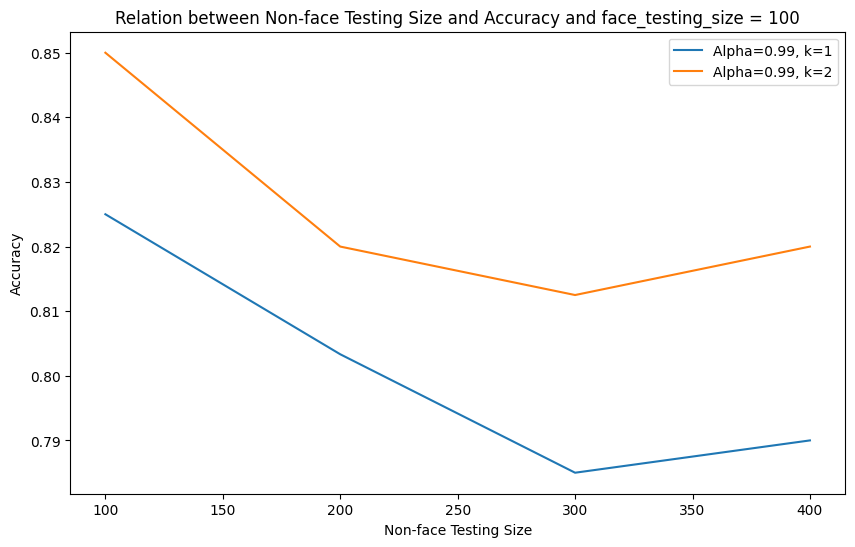 <br>

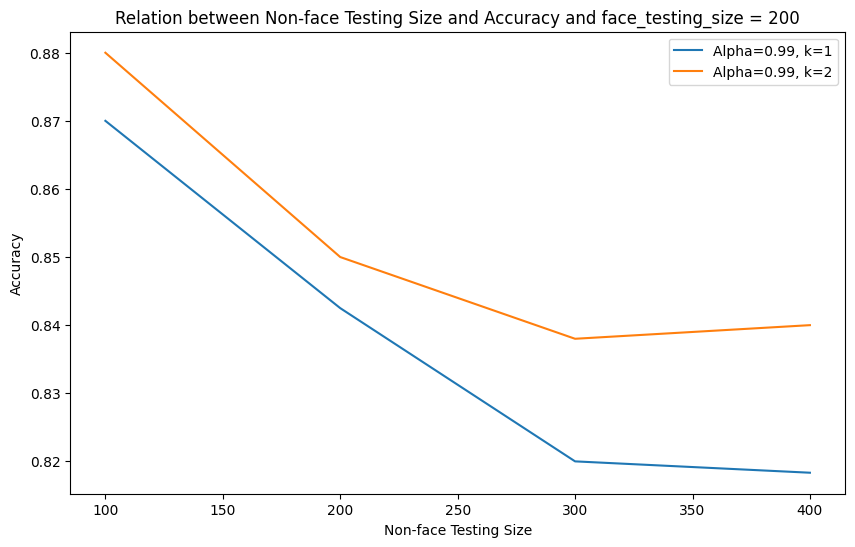
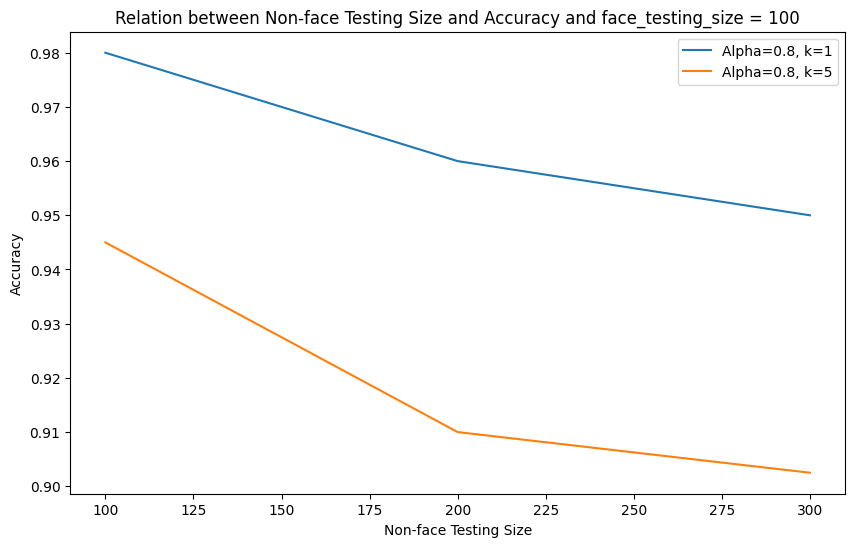
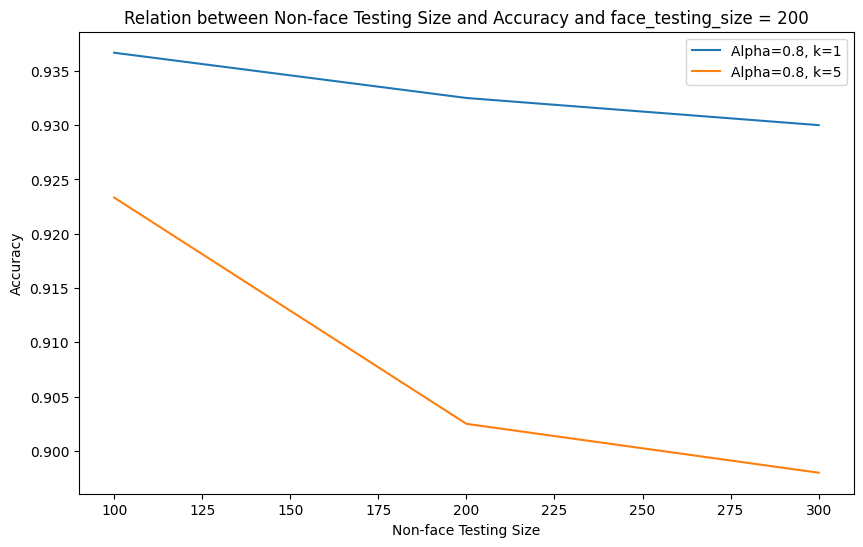



---



# 13.Success Cases

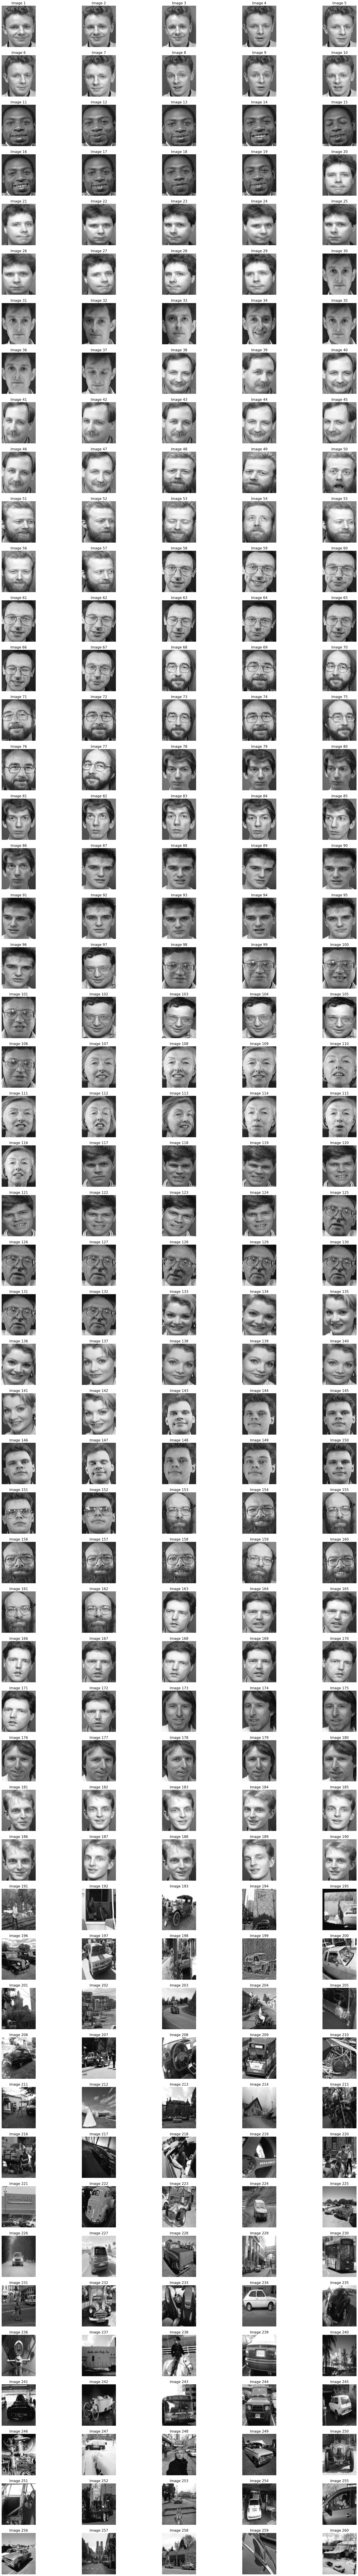



---



# 14.Failure Cases

**bold text**
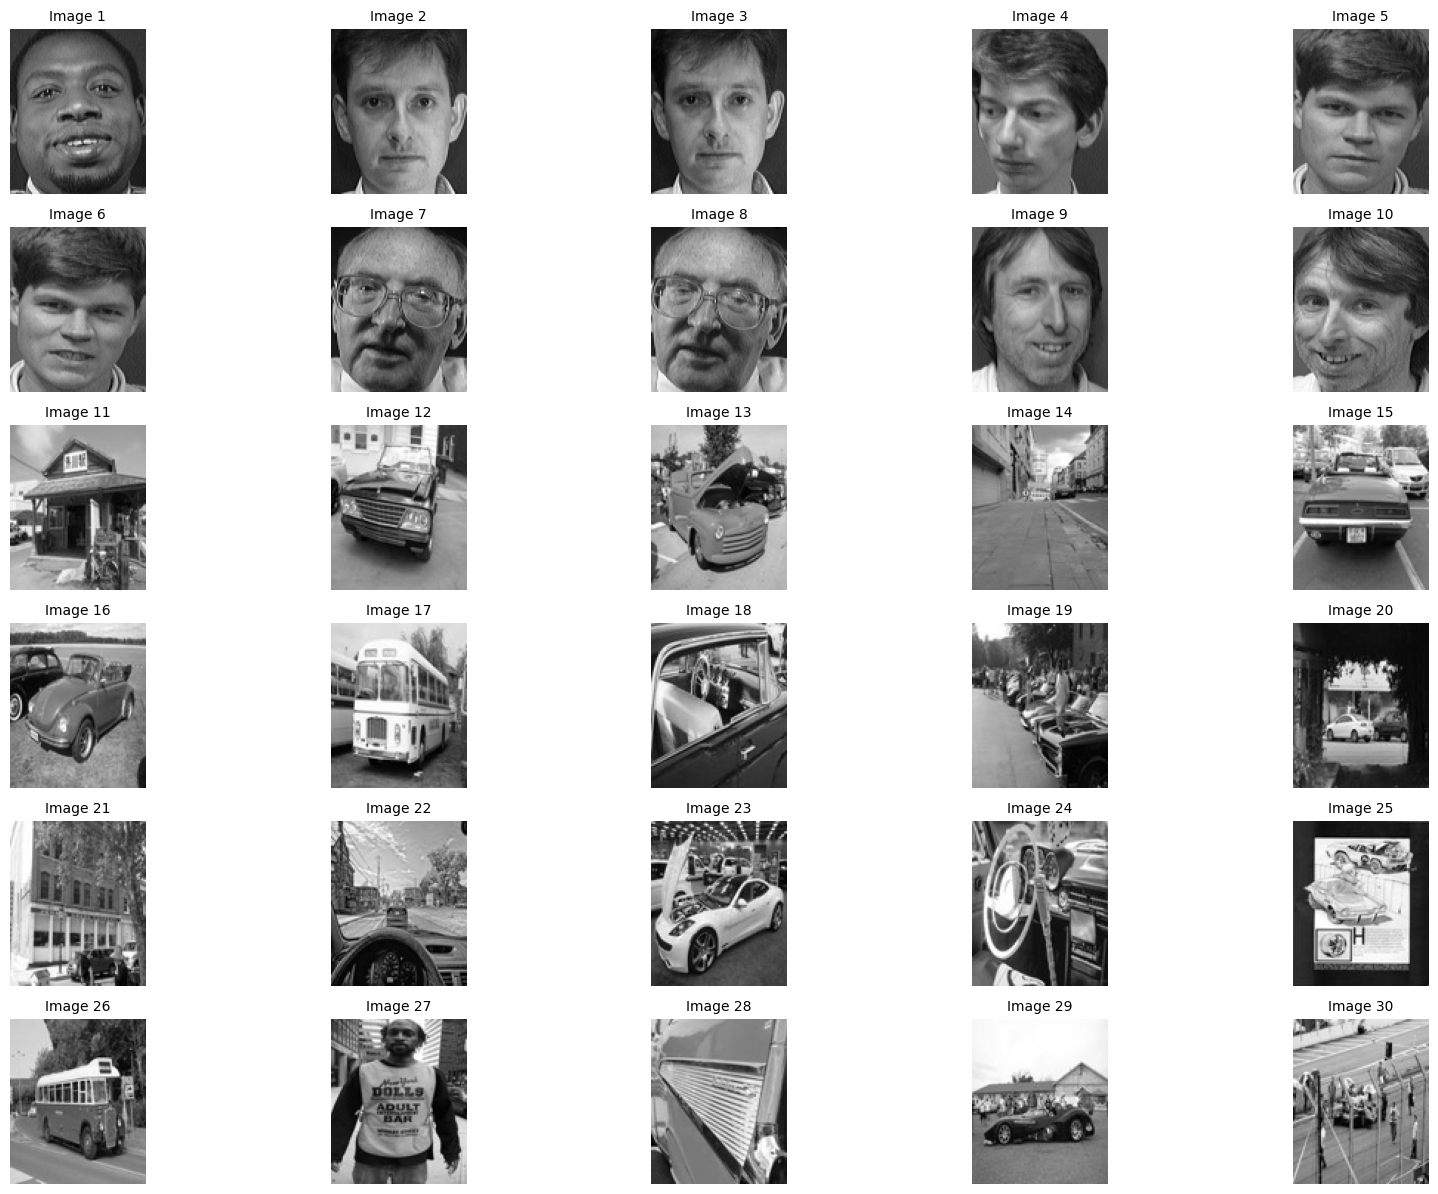



---



# 15.Criticizing the accuracy measure for large numbers of non-faces in training data


Testing with PCA

```
For alpha = 0.8, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 74 / 100 (Accuracy: 74.00%)
Success cases for Label 0: 86 / 100 (Accuracy: 86.00%)
Overall Accuracy: 80.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 74 / 100 (Accuracy: 74.00%)
Success cases for Label 0: 167 / 200 (Accuracy: 83.50%)
Overall Accuracy: 80.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 74 / 100 (Accuracy: 74.00%)
Success cases for Label 0: 257 / 300 (Accuracy: 85.67%)
Overall Accuracy: 82.75 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 155 / 200 (Accuracy: 77.50%)
Success cases for Label 0: 86 / 100 (Accuracy: 86.00%)
Overall Accuracy: 80.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 155 / 200 (Accuracy: 77.50%)
Success cases for Label 0: 167 / 200 (Accuracy: 83.50%)
Overall Accuracy: 80.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 155 / 200 (Accuracy: 77.50%)
Success cases for Label 0: 257 / 300 (Accuracy: 85.67%)
Overall Accuracy: 82.39999999999999 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 66 / 100 (Accuracy: 66.00%)
Success cases for Label 0: 87 / 100 (Accuracy: 87.00%)
Overall Accuracy: 76.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 66 / 100 (Accuracy: 66.00%)
Success cases for Label 0: 171 / 200 (Accuracy: 85.50%)
Overall Accuracy: 79.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 66 / 100 (Accuracy: 66.00%)
Success cases for Label 0: 264 / 300 (Accuracy: 88.00%)
Overall Accuracy: 82.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 142 / 200 (Accuracy: 71.00%)
Success cases for Label 0: 87 / 100 (Accuracy: 87.00%)
Overall Accuracy: 76.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 142 / 200 (Accuracy: 71.00%)
Success cases for Label 0: 171 / 200 (Accuracy: 85.50%)
Overall Accuracy: 78.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 142 / 200 (Accuracy: 71.00%)
Success cases for Label 0: 264 / 300 (Accuracy: 88.00%)
Overall Accuracy: 81.2 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 94 / 100 (Accuracy: 94.00%)
Success cases for Label 0: 81 / 100 (Accuracy: 81.00%)
Overall Accuracy: 87.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 94 / 100 (Accuracy: 94.00%)
Success cases for Label 0: 155 / 200 (Accuracy: 77.50%)
Overall Accuracy: 83.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 94 / 100 (Accuracy: 94.00%)
Success cases for Label 0: 243 / 300 (Accuracy: 81.00%)
Overall Accuracy: 84.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 184 / 200 (Accuracy: 92.00%)
Success cases for Label 0: 81 / 100 (Accuracy: 81.00%)
Overall Accuracy: 88.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 184 / 200 (Accuracy: 92.00%)
Success cases for Label 0: 155 / 200 (Accuracy: 77.50%)
Overall Accuracy: 84.75 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.8, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 184 / 200 (Accuracy: 92.00%)
Success cases for Label 0: 243 / 300 (Accuracy: 81.00%)
Overall Accuracy: 85.39999999999999 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 85 / 100 (Accuracy: 85.00%)
Success cases for Label 0: 95 / 100 (Accuracy: 95.00%)
Overall Accuracy: 90.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 85 / 100 (Accuracy: 85.00%)
Success cases for Label 0: 189 / 200 (Accuracy: 94.50%)
Overall Accuracy: 91.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 85 / 100 (Accuracy: 85.00%)
Success cases for Label 0: 280 / 300 (Accuracy: 93.33%)
Overall Accuracy: 91.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 167 / 200 (Accuracy: 83.50%)
Success cases for Label 0: 95 / 100 (Accuracy: 95.00%)
Overall Accuracy: 87.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 167 / 200 (Accuracy: 83.50%)
Success cases for Label 0: 189 / 200 (Accuracy: 94.50%)
Overall Accuracy: 89.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 1, Training set size = 800 (200 face,  600 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 167 / 200 (Accuracy: 83.50%)
Success cases for Label 0: 280 / 300 (Accuracy: 93.33%)
Overall Accuracy: 89.4 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 80 / 100 (Accuracy: 80.00%)
Success cases for Label 0: 96 / 100 (Accuracy: 96.00%)
Overall Accuracy: 88.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 80 / 100 (Accuracy: 80.00%)
Success cases for Label 0: 191 / 200 (Accuracy: 95.50%)
Overall Accuracy: 90.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 80 / 100 (Accuracy: 80.00%)
Success cases for Label 0: 284 / 300 (Accuracy: 94.67%)
Overall Accuracy: 91.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 160 / 200 (Accuracy: 80.00%)
Success cases for Label 0: 96 / 100 (Accuracy: 96.00%)
Overall Accuracy: 85.33333333333334 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 160 / 200 (Accuracy: 80.00%)
Success cases for Label 0: 191 / 200 (Accuracy: 95.50%)
Overall Accuracy: 87.75 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 2, Training set size = 800 (200 face,  600 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 160 / 200 (Accuracy: 80.00%)
Success cases for Label 0: 284 / 300 (Accuracy: 94.67%)
Overall Accuracy: 88.8 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 94 / 100 (Accuracy: 94.00%)
Overall Accuracy: 92.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 188 / 200 (Accuracy: 94.00%)
Overall Accuracy: 93.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 278 / 300 (Accuracy: 92.67%)
Overall Accuracy: 92.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 94 / 100 (Accuracy: 94.00%)
Overall Accuracy: 90.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 188 / 200 (Accuracy: 94.00%)
Overall Accuracy: 91.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For alpha = 0.95, k = 4, Training set size = 800 (200 face,  600 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 278 / 300 (Accuracy: 92.67%)
Overall Accuracy: 91.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
```


## When we increase the number of non-face images in the training set we can observe:

**Accuracy for Non-Face Label (Label 0):**
As the number of non-face images in the training set increases, the accuracy for the non-face label tends to increase. This is evident from the increasing accuracy percentages observed across different testing set sizes.
For instance, when the training set size is 800 (200 face, 600 non-face) and the testing set size is 200 (100 non-face, 100 face), the accuracy for the non-face label is 86.00%. but with 400 (200 face,  200 nonface), Testing set size = 200 (100 nonface, 100 face) the accuracy decreases to 40.00%.<br><br>

**Overall Accuracy:**

The overall accuracy tends to increase as well as the number of non-face images in the training set increases. This is because the increase in accuracy for the non-face label contributes to a higher overall accuracy, as both face and non-face labels are equally important and face labels approximitaly have the same accuracy measure.<br><br>

**Accuracy for Face Label (Label 1):**

The accuracy for the face label decreases and may even remain stable slightly in some cases as the number of non-face images in the training set increases. This is evident from the increasing accuracy percentages observed for the face label across different testing set sizes.
For example, when the training set size is 800 (200 face, 600 non-face) and the testing set size is 200 (100 non-face, 100 face), the accuracy for the face label is 74.00%%. For 400 (200 face,  200 nonface), Testing set size = 300 (200 nonface, 100 face) the accuracy remains 94.00%.




---





---



# New Section

# New Section

# New Section

# New Section

# New Section

# 16.Split data 7 : 3

In [ ]:
# Select 7 instances per subject for training
training_data = cp.concatenate([D[i*10-9:i*10-3] for i in range(1, 41)])

# Select 3 instances per subject for testing
testing_data = cp.concatenate([D[i*10-3:i*10] for i in range(1, 41)])

# Generate training labels (subjects)
training_data_labels = cp.concatenate([y[i*10-9:i*10-3] for i in range(1, 41)])

# Generate testing labels (subjects)
testing_data_labels = cp.concatenate([y[i*10-3:i*10] for i in range(1, 41)])

In [ ]:
# Define the list of alpha values
alphas = [0.8, 0.85, 0.9, 0.95]

# Initialize an empty dictionary to store the principal component matrices for each alpha value
U_matrices = {}

# Iterate over each alpha value
for alpha in alphas:
    # Compute the principal component matrix for the given alpha and store it in the dictionary
    U_matrices[alpha] = PCA(training_data, alpha)

# Initialize dictionaries to store projected training and test data for each alpha value
projected_training = {}
projected_test = {}

# Iterate over each alpha value and its corresponding principal component matrix
for alpha, U in U_matrices.items():
    # Project the training data onto the principal components and store the result
    projected_training[alpha] = cp.dot(U, training_data.T)

    # Project the test data onto the principal components and store the result
    projected_test[alpha] = cp.dot(U, testing_data.T)

In [ ]:
K_values = [1, 3, 5, 7]

# Compute accuracy for different K values using K-NN classifier for PCA
for alpha in alphas:
  accuracies_knn = []
  for k in K_values:
      accuracies_knn.append(compute_accuracy(cp.asnumpy(projected_training[alpha].T), cp.asnumpy(training_data_labels), cp.asnumpy(projected_test[alpha].T), cp.asnumpy(testing_data_labels), k)[0])

  # Plot the performance measure (accuracy) against the K value for K-NN classifier with PCA
  plot_accuracy_vs_k(K_values, accuracies_knn, f'PCA : alpha = {alpha}')
accuracies_LDA_knn = []
for k in K_values:
  accuracies_LDA_knn.append(compute_accuracy(train_data, training_data_labels.get(), test_data, testing_data_labels.get(), k)[0])
plot_accuracy_vs_k(K_values, accuracies_LDA_knn,"LDA")

### **Results:**
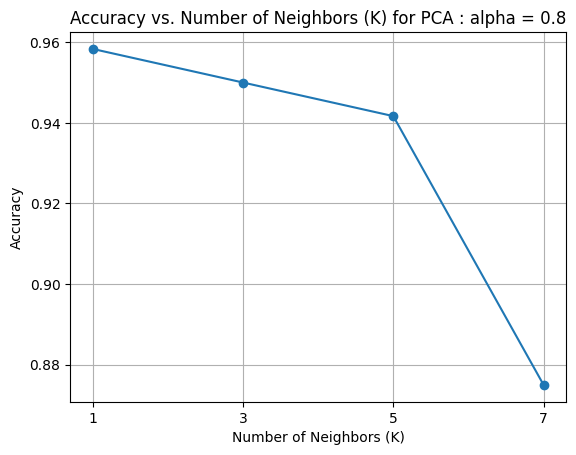
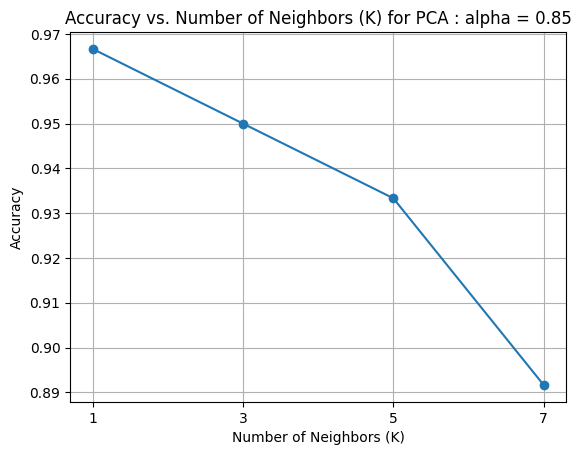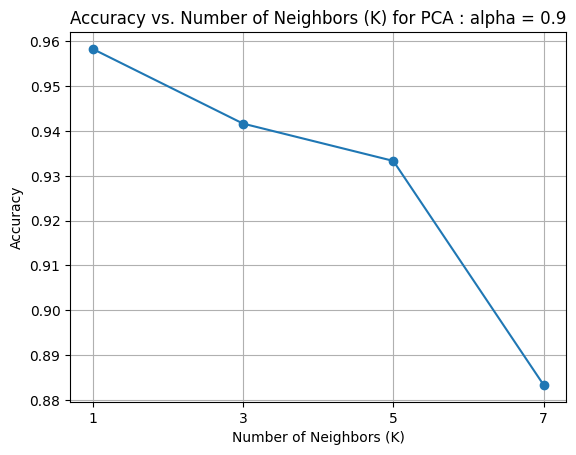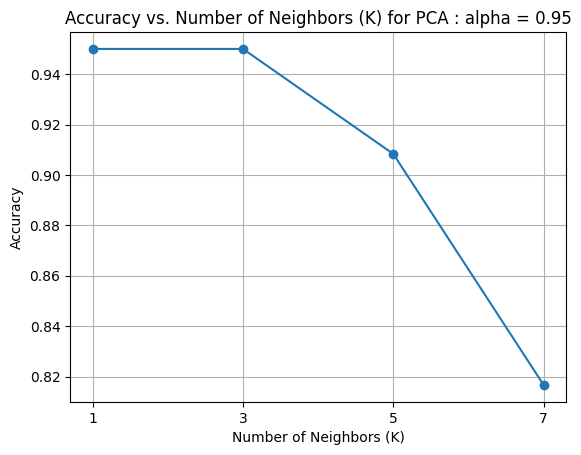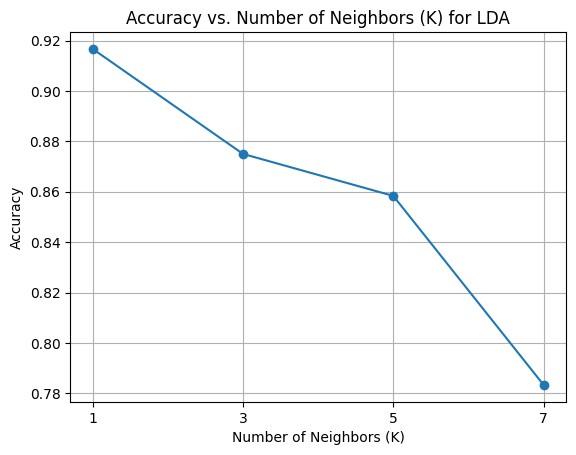



---



# 17.Comparison between LDA and QDA


## QDA accuracy and time complexities

#### Testing with QDA


```
Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Overall Accuracy: 50.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (200 nonface, 100 face)
Overall Accuracy: 59.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Overall Accuracy: 65.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Overall Accuracy: 42.66666666666667 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (200 nonface, 200 face)
Overall Accuracy: 51.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Overall Accuracy: 57.8 %
------------------------------------------------------------------------------------------------------------------------------------------------------

```
**The accuracy less than LDA here but the average running time for one case is 500 ms**

## LDA accuracy and time complexities

```
Testing with LDA
Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 70 / 100 (Accuracy: 70.00%)
Overall Accuracy: 85.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 118 / 200 (Accuracy: 59.00%)
Overall Accuracy: 72.66666666666667 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 173 / 300 (Accuracy: 57.67%)
Overall Accuracy: 68.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 194 / 200 (Accuracy: 97.00%)
Success cases for Label 0: 72 / 100 (Accuracy: 72.00%)
Overall Accuracy: 88.66666666666667 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 198 / 200 (Accuracy: 99.00%)
Success cases for Label 0: 136 / 200 (Accuracy: 68.00%)
Overall Accuracy: 83.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 198 / 200 (Accuracy: 99.00%)
Success cases for Label 0: 196 / 300 (Accuracy: 65.33%)
Overall Accuracy: 78.8 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 72 / 100 (Accuracy: 72.00%)
Overall Accuracy: 86.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 123 / 200 (Accuracy: 61.50%)
Overall Accuracy: 74.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 184 / 300 (Accuracy: 61.33%)
Overall Accuracy: 71.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 194 / 200 (Accuracy: 97.00%)
Success cases for Label 0: 78 / 100 (Accuracy: 78.00%)
Overall Accuracy: 90.66666666666666 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 195 / 200 (Accuracy: 97.50%)
Success cases for Label 0: 141 / 200 (Accuracy: 70.50%)
Overall Accuracy: 84.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 197 / 200 (Accuracy: 98.50%)
Success cases for Label 0: 205 / 300 (Accuracy: 68.33%)
Overall Accuracy: 80.4 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 60 / 100 (Accuracy: 60.00%)
Overall Accuracy: 80.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (200 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 103 / 200 (Accuracy: 51.50%)
Overall Accuracy: 67.66666666666666 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 100 / 100 (Accuracy: 100.00%)
Success cases for Label 0: 138 / 300 (Accuracy: 46.00%)
Overall Accuracy: 59.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 197 / 200 (Accuracy: 98.50%)
Success cases for Label 0: 62 / 100 (Accuracy: 62.00%)
Overall Accuracy: 86.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (200 nonface, 200 face)
Success cases for Label 1: 199 / 200 (Accuracy: 99.50%)
Success cases for Label 0: 112 / 200 (Accuracy: 56.00%)
Overall Accuracy: 77.75 %
------------------------------------------------------------------------------------------------------------------------------------------------------
Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 200 / 200 (Accuracy: 100.00%)
Success cases for Label 0: 155 / 300 (Accuracy: 51.67%)
Overall Accuracy: 71.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------

```
The average time complexity for one case is 25sec before using pseudo inverses and around 20min after.



---



# 18. Comparison between PCA and KernelPCA


## PCA accuracy and time complexities
as mentioned ealier in accuracy and time complexity is 25 sec on average

## kernel PCA


```
Testing with Kernel PCA
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 93.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 93.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 96.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 92.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 92.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 1, Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 95.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 2, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 93.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 2, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 93.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 2, Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 87 / 100 (Accuracy: 87.00%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 96.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 2, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 92.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 2, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 92.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 2, Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 95.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 3, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 98 / 100 (Accuracy: 98.00%)
Overall Accuracy: 94.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 3, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 98 / 100 (Accuracy: 98.00%)
Overall Accuracy: 94.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 3, Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 97.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 3, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 175 / 200 (Accuracy: 87.50%)
Success cases for Label 0: 98 / 100 (Accuracy: 98.00%)
Overall Accuracy: 91.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 3, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 175 / 200 (Accuracy: 87.50%)
Success cases for Label 0: 98 / 100 (Accuracy: 98.00%)
Overall Accuracy: 91.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 3, Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 175 / 200 (Accuracy: 87.50%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 94.6 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 5, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 99 / 100 (Accuracy: 99.00%)
Overall Accuracy: 95.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 5, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 99 / 100 (Accuracy: 99.00%)
Overall Accuracy: 95.0 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 5, Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 97.25 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 5, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 175 / 200 (Accuracy: 87.50%)
Success cases for Label 0: 99 / 100 (Accuracy: 99.00%)
Overall Accuracy: 91.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 5, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 175 / 200 (Accuracy: 87.50%)
Success cases for Label 0: 99 / 100 (Accuracy: 99.00%)
Overall Accuracy: 91.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 5, Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 175 / 200 (Accuracy: 87.50%)
Success cases for Label 0: 298 / 300 (Accuracy: 99.33%)
Overall Accuracy: 94.6 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 7, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 95.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 7, Training set size = 200 (100 face,  100 nonface), Testing set size = 200 (100 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 95.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 7, Training set size = 200 (100 face,  100 nonface), Testing set size = 400 (300 nonface, 100 face)
Success cases for Label 1: 91 / 100 (Accuracy: 91.00%)
Success cases for Label 0: 299 / 300 (Accuracy: 99.67%)
Overall Accuracy: 97.5 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 7, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 92.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 7, Training set size = 200 (100 face,  100 nonface), Testing set size = 300 (100 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 100 / 100 (Accuracy: 100.00%)
Overall Accuracy: 92.33333333333333 %
------------------------------------------------------------------------------------------------------------------------------------------------------
For k = 7, Training set size = 200 (100 face,  100 nonface), Testing set size = 500 (300 nonface, 200 face)
Success cases for Label 1: 177 / 200 (Accuracy: 88.50%)
Success cases for Label 0: 299 / 300 (Accuracy: 99.67%)
Overall Accuracy: 95.19999999999999 %
------------------------------------------------------------------------------------------------------------------------------------------------------
```
better accuracy and better time complexity around 200 ms on average for one case




---

